In [525]:
from dataclasses import dataclass
from scipy import stats, odr
import matplotlib.pyplot as plt
import numpy as np
from data import DataSeries

# Signals
Signals are used to predict the next day's price based on historical price data. Signals are provided daily measurements of price history over the past 7 days, and return a boolean value indicating whether the price is expected to increase or decrease the next day.


# Linear Signal
This signal predicts the next day's price by fitting a linear regression to the price data and extrapolating the next day's price.
It can be customized to consider a different number of days in the past to fit the linear regression.

The signal also checks for correlation strength using the r-value (pearson correlation coefficient) and only triggers if the correlation strength is above a certain threshold.

In [526]:
@dataclass
class LinearSignal:
    days_to_consider: int

    def predict_price(self, price_history: DataSeries) -> bool:
        x = range(-1 - self.days_to_consider, 0)
        y = [price_history[i].price for i in x]

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        return slope > 0 and r_value > 0.4

# Quadratic Signal
This signal predicts the next day's price by fitting a quadratic regression to the price data and extrapolating the next day's price.
This should be able to detect recent peaks and troughs in the price data better than the linear signal, and adjust the prediction accordingly.

In [527]:
@dataclass
class QuadraticSignal:
    days_to_consider: int

    def predict_price(self, price_history: DataSeries) -> bool:
        x = range(-1 - self.days_to_consider, 0)
        y = [price_history[i].price for i in x]

        price_data = odr.Data(x, y)
        odr_obj = odr.ODR(price_data, odr.quadratic)
        output = odr_obj.run()
        coeffs = output.beta
        
        derivative = coeffs[1]
        
        return derivative > 15

# Testing the signal
Signals are back-tested using the `test_signal` function, which simulates the signal on historical ETH data.
Data is imported from a csv file containing daily records of ETH price action over the past 5 years.
The signal is used to change the leverage of the portfolio between 1x and 0.5x based on the signal's prediction.

A more refined approach could be used in the future to optimize the leverage based on the signal's confidence level.

In [528]:
data = DataSeries.from_csv('resources/eth-usd-max.csv')[-365:]  # only use 1 year of data

def test_signal(predictor, name='Investment Strategy', plot_price=True, plot_normalized=False):
    num_correct = 0
    num_true = 0

    eth_prices = np.array([entry.price for entry in data])
    t = np.arange(len(data), dtype=int)
    portfolio = np.zeros_like(t, dtype=float)
    portfolio[0:7] = data[0].price  # first week doesn't count

    leverage = 1
    
    # leverage changes
    increase_leverage = []
    decrease_leverage = []

    for i in range(7, len(data)-1):
        history = data[i-7:i+1]
        prediction = predictor.predict_price(history)

        yesterday = eth_prices[i - 1]
        today = eth_prices[i]

        price_change = today - yesterday
        yesterday_portfolio = portfolio[i - 1]
        num_eth = yesterday_portfolio / yesterday
        portfolio[i] = yesterday_portfolio + (num_eth * price_change * leverage)

        tomorrow = eth_prices[i + 1]
        actual_result = tomorrow > today

        if prediction:
            if leverage != 2:
                increase_leverage.append(i)
            leverage = 2
        else:
            if leverage != 0.5:
                decrease_leverage.append(i)
            leverage = 0.5

        if prediction:
            num_true += 1

        if actual_result == prediction:
            num_correct += 1
    
    increase_leverage.append(len(data) - 1)
    decrease_leverage.append(len(data) - 1)

    if plot_price:
        plt.figure()
        plt.title(name)
        plt.xlabel('Days Passed')
        plt.ylabel('Value ($)')
        plt.plot(t, eth_prices, label='Eth Price')
        plt.plot(t[7:len(data) - 1], portfolio[7:len(data) - 1], label='Portfolio Value')
        for start, end in zip(increase_leverage, decrease_leverage):
            plt.axvspan(start, end, color='g', alpha=0.2)
        for start, end in zip(decrease_leverage, increase_leverage[1:]):
            plt.axvspan(start, end, color='r', alpha=0.2)
        plt.legend()
        plt.show()

    if plot_normalized:
        plt.figure()
        plt.title(name)
        plt.xlabel('Days Passed')
        plt.ylabel('Value (ETH)')
        plt.plot(t, eth_prices/eth_prices, label='Eth Price')
        plt.plot(t[7:len(data)-1], (portfolio / eth_prices)[7:len(data)-1], label='Portfolio Value')
        for start, end in zip(increase_leverage, decrease_leverage):
            plt.axvspan(start, end, color='g', alpha=0.2)
        for start, end in zip(decrease_leverage, increase_leverage[1:]):
            plt.axvspan(start, end, color='r', alpha=0.2)
        plt.legend()
        plt.show()

    print(name)
    print(f'Bullish ratio: {num_true / (len(data) - 8)}')
    print(f'Accuracy: {num_correct / (len(data) - 8)}')
    print()

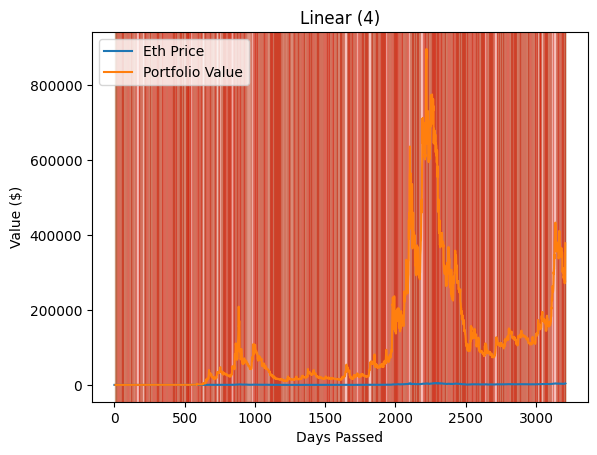

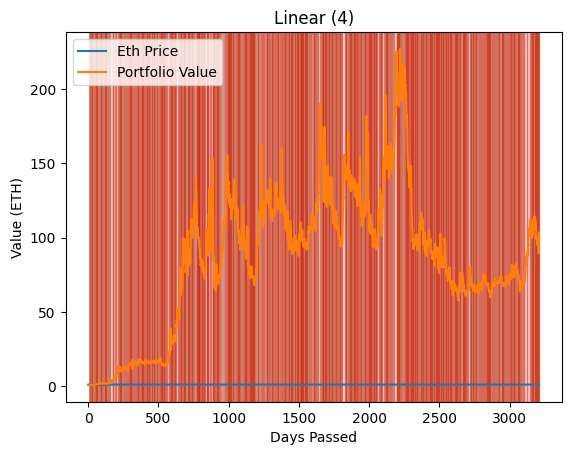

Linear (4)
Bullish ratio: 0.42473454091193
Accuracy: 0.4946908182386009


In [529]:
signal = LinearSignal(4)
test_signal(signal, name=f'Linear ({signal.days_to_consider})', plot_price=True, plot_normalized=True)

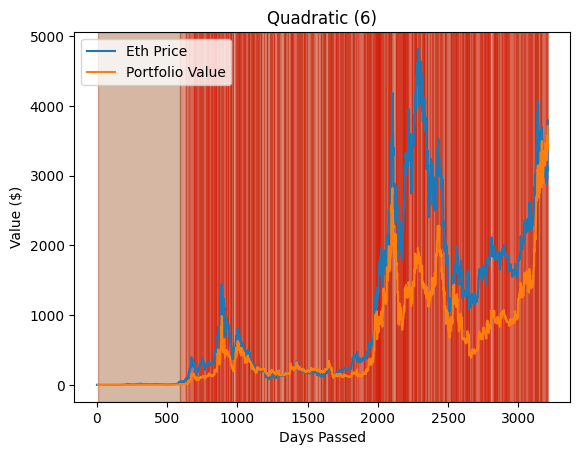

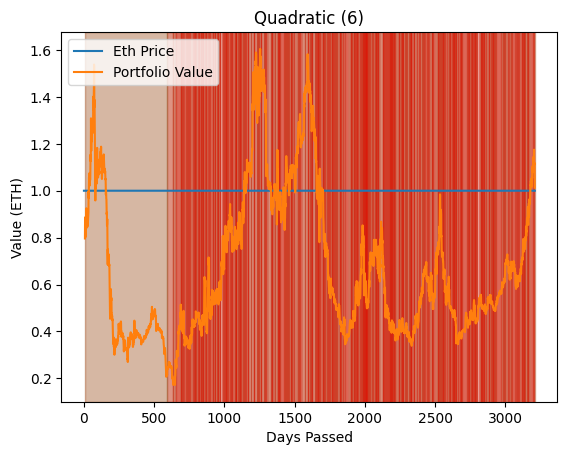

Quadratic (6)
Bullish ratio: 0.2948157401623985
Accuracy: 0.49531542785758903


In [530]:
signal = QuadraticSignal(6)
test_signal(signal, name=f'Quadratic ({signal.days_to_consider})', plot_price=True, plot_normalized=True)